In [1]:
%matplotlib inline
import numpy as np
from PIL import Image
from keras.models import model_from_json
from tiramisu import create_tiramisu
from mask_utils import get_images, get_input_prediction_tiles, image_from_tiles

Using TensorFlow backend.


In [2]:
with open("data/results/model_171015.json","r") as f:
    json_string = f.read()
model = model_from_json(json_string)

In [3]:
# supposed to be best model
model.load_weights("data/results/mask_weights_171016_094411.h5")
# last model from last night
#model.load_weights("data/results/mask_weights_171015_231421.h5")

In [7]:
#base_name = 'chromatic'
for base_name in ['chromatic','chromatic_piano','gen_one','gen_two','twinkle']:
    print(f"predicting {base_name}")
    score_image, mask_image = get_images(base_name)
    input_tiles = get_input_prediction_tiles(score_image)
    pred_tiles = model.predict(input_tiles)
    pred_one = image_from_tiles(score_image.width, score_image.height, 
                                input_tiles.shape[0], pred_tiles, 1)
    #pred_one
    with open(f"data/results/pred_mask_{base_name}.png",'wb') as f:
        pred_one.save(f)

predicting chromatic
predicting chromatic_piano
predicting gen_one
predicting gen_two
predicting twinkle


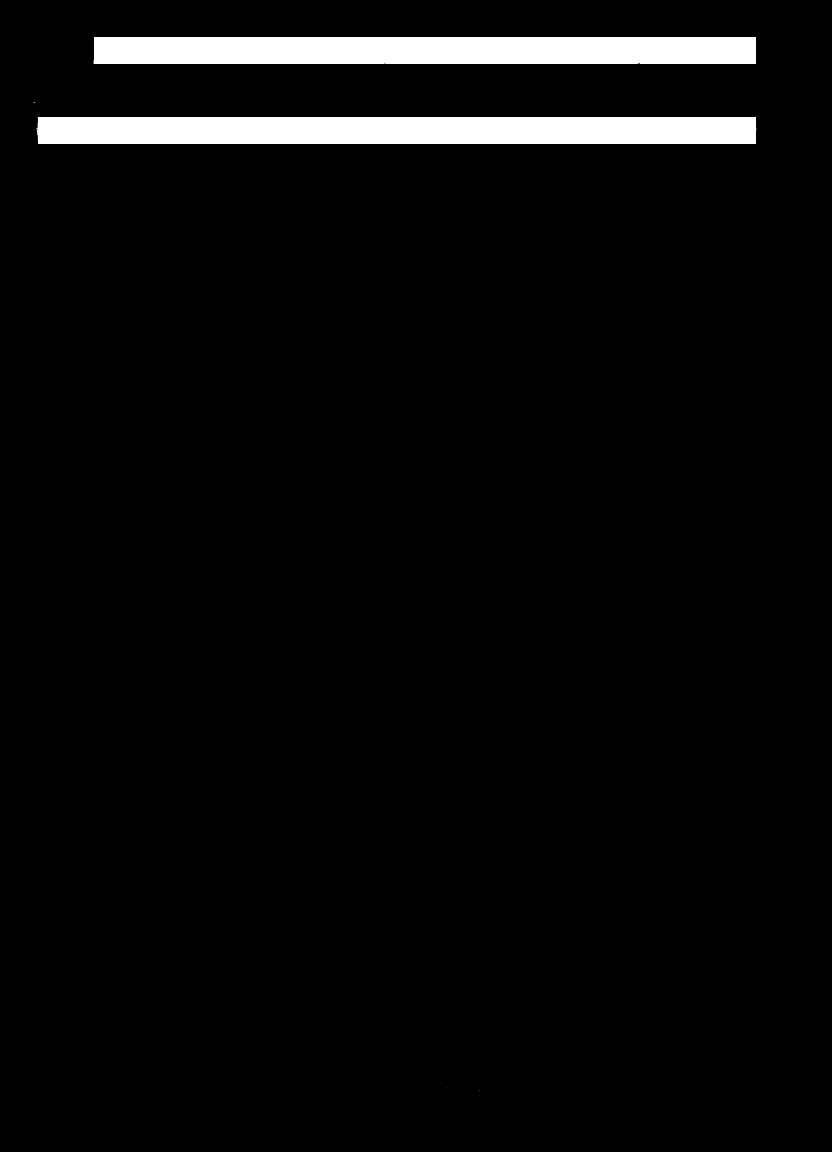

In [8]:
pred_one

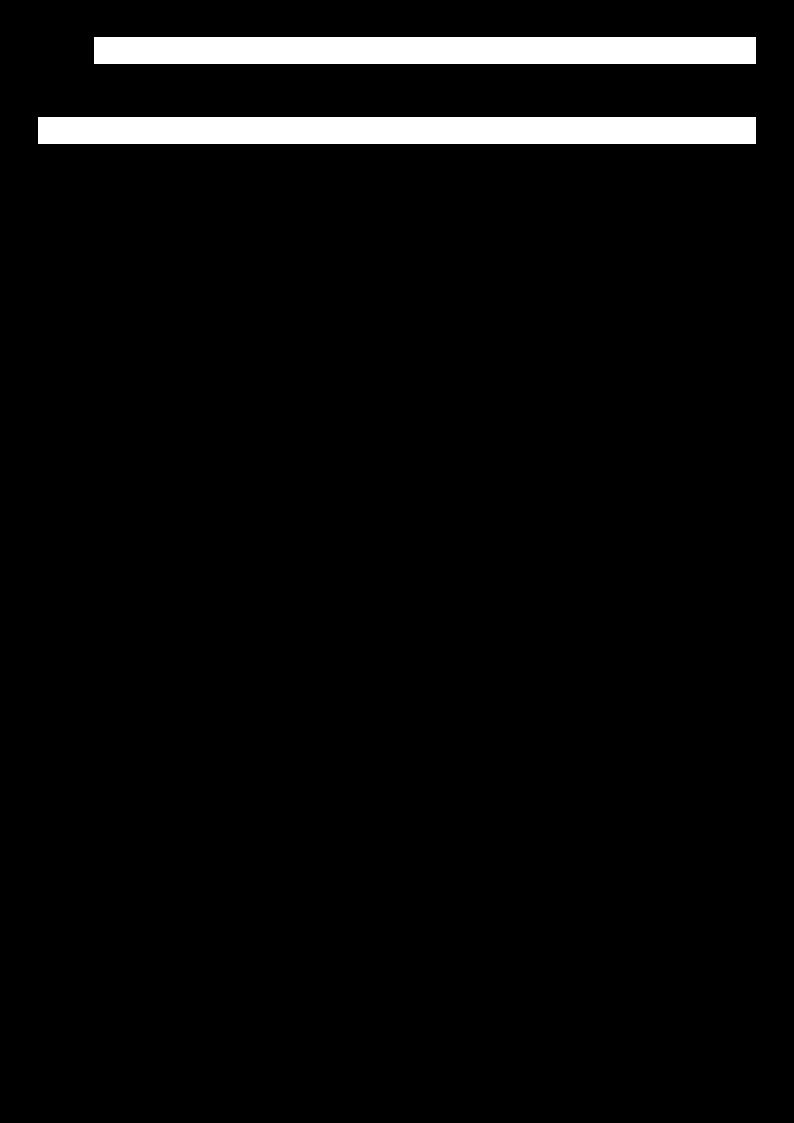

In [9]:
mask_image